In [2]:
import numpy as np
from numpy.fft import rfft,irfft, rfftfreq
import scipy
import scipy.interpolate as scint
import vlsr
import vlsr_iraf
from xkeckhelio import x_keckhelio
import fitsio
dir='/astro/u/anze/bmxdata/reduced/pas/191009_2100'
import matplotlib.pyplot as plt
import bmxhi4
from matplotlib.colors import LogNorm

In [3]:
freq=fitsio.read(dir+'/cut1/freq.fits')
da=fitsio.read(dir+'/cut1/auto_3.fits')
da=da[:da.shape[0]//32*32,:]
da=da[:,:]-np.outer(0.25*(da[:,0]+da[:,1]+da[:,-1]+da[:,-2]),np.ones(da.shape[1]))
da[da<0]=0
da=da.reshape(-1,32,da.shape[1]).mean(axis=1)


In [4]:
mjd=fitsio.read(dir+'/mjd.fits')['mjd'][:da.shape[0]*32]
coords=fitsio.read(dir+'/coords.fits')
dec=coords['dec'][:da.shape[0]*32]/np.pi*180
ra=coords['ra'][:da.shape[0]*32]/np.pi*180

In [5]:
ra=ra.reshape(-1,32).mean(axis=1)
dec=dec.reshape(-1,32).mean(axis=1)
mjd=mjd.reshape(-1,32).mean(axis=1)

In [6]:
keck=np.squeeze(np.array([x_keckhelio(r,d,m) for r,d,m in zip(ra,dec,mjd)]))

In [7]:
v1=vlsr.vlsr(ra,dec,mjd)
v2=vlsr_iraf.vlsr(ra,dec,mjd)

        Use `lat` instead. [vlsr]


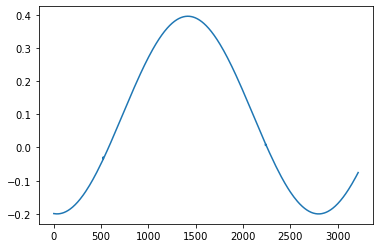

In [8]:
#plt.plot(ra,v1[0])
#plt.plot(ra,v1[1])
#plt.plot(ra,v1[2])
#plt.plot(ra,keck-v1[0],'k-') ### this is the one unsed by sheey
#plt.plot(ra,-v1[1]-v1[0],'r-') ### this is the one unsed by fixed vlsr
plt.plot(v1[1]+keck)

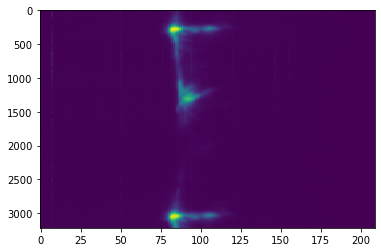

In [9]:
plt.imshow(da,aspect='auto')

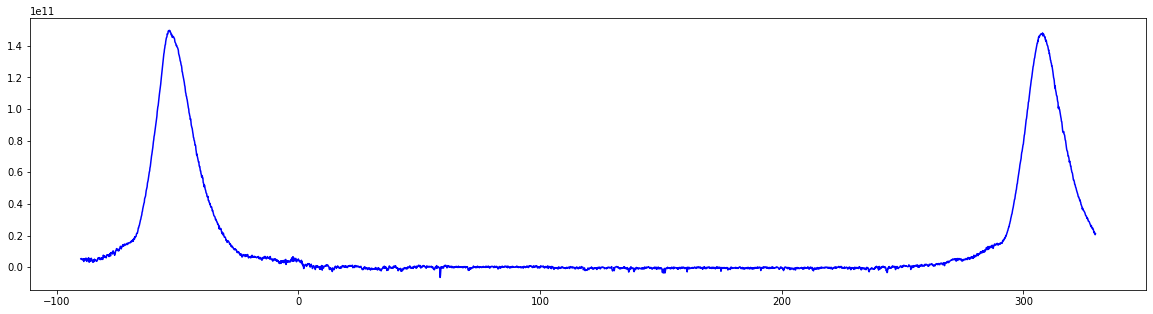

In [10]:
plt.figure(figsize=(20,5))
plt.plot(ra,da[:,82]-da[:,50],'b-')

In [13]:
nu0=1420.405751
c0=2.99792e8
((freq-nu0)/nu0*c0)[[0,-1]]

array([-294914.78125577,  441943.0557659 ])

In [14]:
freq.shape

(209,)

In [15]:
3*(hi.vel[1]-hi.vel[0]), velint[1]-velint[0]

NameError: name 'hi' is not defined

In [16]:
hi=bmxhi4.BMX4PI()

Reading /astro/u/anze/bmxdata/HI4PI/bmxslice.fits ...


In [17]:
def Observed (self,rain,decin,sigmalat,sigmalon):
    """ Returns an observed signal for a given ra,dec fit                                                          
            with a certain sigma in beam in lat and longitude """
    print(self.sky.shape)
    ## we need to reorder ra into an ascending
    NRA=len(self.ra)
    NV=len(self.vel)
    edge=10
    chunk1=np.where(rain>=-edge)
    chunk2=np.where((rain<+edge) & (rain+360>rain[-1]))
    rain=np.hstack((rain[chunk1],rain[chunk2]+360))
    decin=np.hstack((decin[chunk1],decin[chunk2]))
    deccent=scint.interp1d(rain,decin)(self.ra)
    ddec=np.outer (self.dec,np.ones(len(self.ra)),)-np.outer(np.ones(len(self.dec)),deccent)
    latbeam=np.exp(-ddec**2/(2*sigmalat**2))
    latbeamnorm=latbeam.sum(axis=0)
    latbeam/=np.outer(np.ones(len(self.dec)),latbeamnorm)
    #plt.plot(latbeam)
    freq=rfftfreq(len(self.ra))*360.0/(2*np.pi)
    longbeam=np.exp(-freq**2*sigmalon**2/2)
    plt.plot(longbeam[:30])
    output=np.zeros((len(self.vel),len(self.ra)))
    for i in range(NV):
        tsig=(self.sky[i]*latbeam).sum(axis=0)
        output[i,:]=irfft(rfft(tsig)*longbeam,NRA)
    output[1:-1,:]=(output[1:-1,:]+output[0:-2,:]+output[2:,:])/3
    output=np.array(output)
    return scint.RectBivariateSpline(self.vel,360-self.ra,output)
    

(699, 288, 4321)


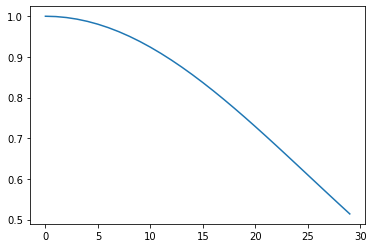

In [18]:
interp=Observed(hi,ra,dec,3,3)
#interp2=Observed(hi,ra,dec-5,4,4)

In [19]:
raint=np.copy(ra)
raint-=180
raint[raint<0]+=360
raint[raint>360]-=360
velint=((nu0-freq)/nu0*c0)
pred=np.array([interp(velint[::-1]-dv*1e3,360-ra)[::-1] for dv,ra in zip(-v1[1]-v1[0],raint)])[:,:,0]
pred[pred<0]=0
#pred2=np.array([interp2(velint[::-1]-dv*1e3,360-ra)[::-1] for dv,ra in zip(keck-v1[0],raint)])[:,:,0]

(1420, 1421.5)

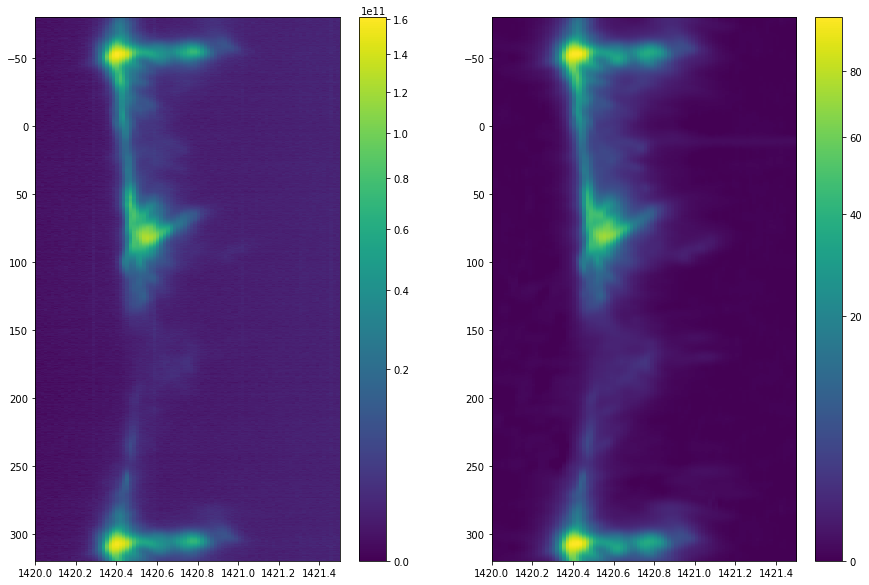

In [20]:
plt.figure(figsize=(15,10))
si=77
ei=3142
plt.subplot(1,2,1)
from astropy.visualization import simple_norm
norm = simple_norm(da, 'sqrt')
plt.imshow(da[si-12:ei-12,:],aspect='auto',extent=(freq[0],freq[-1],ra[ei],ra[si]),origin='upper',norm=norm)
plt.colorbar()
plt.xlim(1420,1421.5)
plt.subplot(1,2,2)
norm = simple_norm(pred, 'sqrt')
plt.imshow(pred[si:ei,:],aspect='auto', extent=(freq[0],freq[-1],ra[ei],ra[si]),origin='upper',norm=norm)

plt.colorbar()
plt.xlim(1420,1421.5)

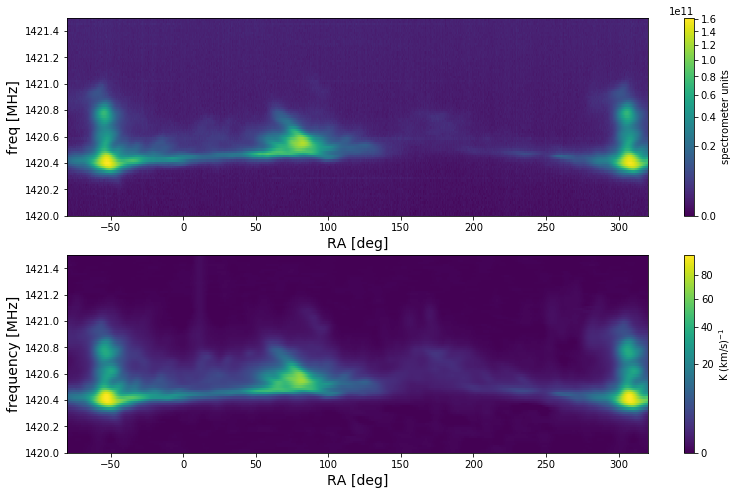

In [198]:
plt.figure(figsize=(13,8))
si=77
ei=3142
plt.subplot(2,1,1)
from astropy.visualization import simple_norm
norm = simple_norm(da, 'sqrt')
plt.imshow(da[si-12:ei-12,:].T,aspect='auto',extent=(ra[si],ra[ei],freq[0],freq[-1]),origin='lower',norm=norm)
cbar = plt.colorbar()
cbar.set_label('spectrometer units', rotation=90)
plt.ylim(1420,1421.5)
#plt.plot([-50,-50],[1420,1421],'r-')
plt.xlabel("RA [deg]",fontsize=14)
plt.ylabel("freq [MHz]",fontsize=14)
plt.subplot(2,1,2)
norm = simple_norm(pred, 'sqrt')
plt.imshow(pred[si:ei,:].T,aspect='auto', extent=(ra[si],ra[ei],freq[0],freq[-1]),origin='lower',norm=norm)
cbar = plt.colorbar()
cbar.set_label('K (km/s)$^{-1}$', rotation=90)
plt.ylim(1420,1421.5)
plt.xlabel("RA [deg]",fontsize=14)
plt.ylabel("frequency [MHz]",fontsize=14)
plt.savefig("bmx21.png",dpi=300)
#plt.plot([-50,-50],[1420,1421],'r-')

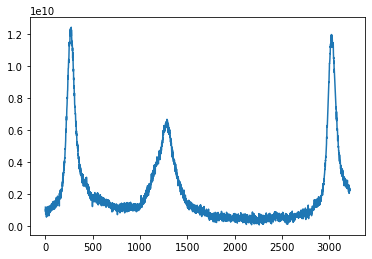

In [82]:
plt.plot(da.mean(axis=1))
#plt.plot(pred[112:-87,50:125].mean(axis=1)*1.5e9)

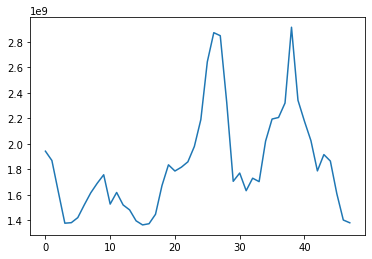

In [52]:
cal=da[100:-46,50:125].mean(axis=1)/pred[112:-34,50:125].mean(axis=1)
plt.plot(cal.reshape(-1,64).mean(axis=1))

In [87]:
np.where(ra>320)

(array([3142, 3143, 3144, 3145, 3146, 3147, 3148, 3149, 3150, 3151, 3152,
        3153, 3154, 3155, 3156, 3157, 3158, 3159, 3160, 3161, 3162, 3163,
        3164, 3165, 3166, 3167, 3168, 3169, 3170, 3171, 3172, 3173, 3174,
        3175, 3176, 3177, 3178, 3179, 3180, 3181, 3182, 3183, 3184, 3185,
        3186, 3187, 3188, 3189, 3190, 3191, 3192, 3193, 3194, 3195, 3196,
        3197, 3198, 3199, 3200, 3201, 3202, 3203, 3204, 3205, 3206, 3207,
        3208, 3209, 3210, 3211, 3212, 3213, 3214, 3215, 3216, 3217]),)

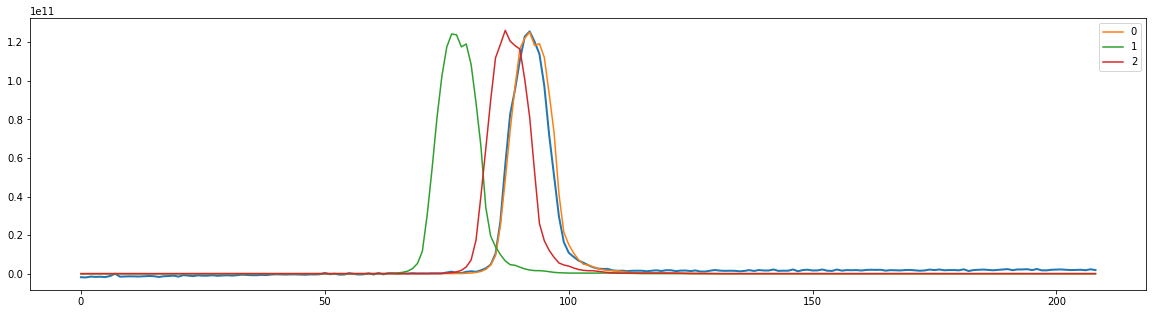

In [307]:
plt.figure(figsize=(20,5))
plt.plot(dafix[1300,:],lw=2)
for ii,var in enumerate([v1[0]-keck,v1[0]+v1[1],v2[0]+v2[1]]):
    pred=np.array([interp(velint[::-1]+dv*1e3,360-ra)[::-1] for dv,ra in zip(var,raint)])[:,:,0]
    plt.plot(3e10*pred[1300,:],label=str(ii))
    
plt.legend()

In [3]:
plt.plot(ra,-keck)
#plt.plot(ra,v1[1])
plt.plot(ra,np.hstack((v1[1][:522],-v1[1][2238:522:-1],v1[1][2238:])))

NameError: name 'ra' is not defined

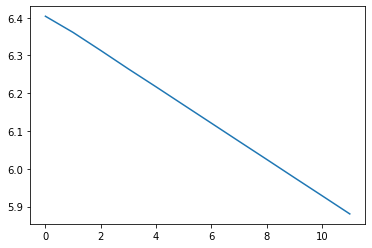

In [329]:
#plt.plot(v1[1][522:])
plt.plot(v1[1][2238:2250])

In [367]:
dax=fitsio.read(dir+'/cut1/cross_34.fits',ext=1)
dax=dax[:dax.shape[0]//32*32,:]
dax=dax.reshape(-1,32,dax.shape[1]).mean(axis=1)


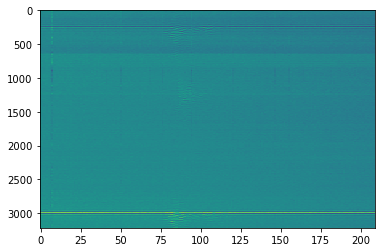

In [368]:
plt.imshow(dax,aspect='auto')

In [386]:
irfft(rfft(range(11)),11)

array([-4.84460956e-16,  1.00000000e+00,  2.00000000e+00,  3.00000000e+00,
        4.00000000e+00,  5.00000000e+00,  6.00000000e+00,  7.00000000e+00,
        8.00000000e+00,  9.00000000e+00,  1.00000000e+01])

In [387]:
hi.NRA

AttributeError: 'BMX4PI' object has no attribute 'NRA'

In [5]:
coords['ra']


array([-1.5708034, -1.5707322, -1.5706611, ...,  5.759413 ,  5.7594843,
        5.7595553], dtype=float32)